# Image classification of images with surface defects

`Maria Magdalena Balos`

A project dedicated to classify images in their main categories based on the surface defects they have.

Dataset used: https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database

Amazing website to check on how cnn work:  https://adamharley.com/nn_vis/cnn/3d.html

## Imports

In [ ]:
import kagglehub
import os
import random as rd
import torch
import torchvision.transforms as transforms
import pytorch_warmup as warmup

from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from trainer import train
from models.alexnet import AlexNet
from models.baseline_cnn import BaselineCNN
from models.lenet import LeNet, LeNetMod, LeNetModNorm, LeNetModNorm2
from models.resnet import ResNet


In [ ]:
# # Import the dataset and define the most important paths
path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")
validation_path_img = os.path.join(path, "NEU-DET", "validation", "images")
validation_path_ann = os.path.join(path, "NEU-DET", "validation", "annotations")
train_path_img = os.path.join(path, "NEU-DET", "train", "images")
train_path_ann = os.path.join(path, "NEU-DET", "train", "annotations")

# Explore the dataset

Training data

In [ ]:
training_categories = os.listdir(train_path_img)
print(f"The training dataset has {len(training_categories)} categories which are: {training_categories}")

In [ ]:
for category in training_categories:
  # Plot 3 random images from the training set for each category
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
  for idx in range(3):
    random_image = rd.randint(1, 240)

    # Plot the image
    image_path = os.path.join(train_path_img, category, f"{category}_{random_image}.jpg")
    with Image.open(image_path) as im:
      image = im.convert("RGB")
    axes[idx].imshow(image)
    axes[idx].set_title(f"{category}_{random_image}", loc="left")
  
  plt.suptitle(f"Category: {category}\n", fontsize=14)
  plt.tight_layout()
  plt.show()
  
  # Check if all images in the category have the same dimensions
  cat_len = len(os.listdir(os.path.join(train_path_img, category)))
  initia_width,initial_height = 0, 0
  for i in range(cat_len):
    image_path = os.path.join(train_path_img, category, f"{category}_{i+1}.jpg")
    with Image.open(image_path) as im:
      width, height = im.size
      if i == 0:
        initia_width = width
        initial_height = height
      else:
        if width != initia_width or height != initial_height:
          print(f"Image {i+1} in category {category} has different dimensions: {width}x{height} vs {initia_width}x{initial_height}")
  print(f"Image dimmensions: {initia_width} x {initial_height} in category {category}")
  print(f"The category {category} in training has {cat_len} images.\n\n")

Check what's in the annotation xml files.

In [ ]:
ann_sample = os.path.join(train_path_ann, "pitted_surface_105.xml")
with open(ann_sample) as f:
    xml_content = f.read()
    print(xml_content)

In [ ]:
print(f"The validation dataset has: {len(training_categories) * len(os.listdir(os.path.join(train_path_img, category)))} images")

## Validation

In [ ]:
validation_categories = os.listdir(validation_path_img)
print(f"The validation dataset has {len(validation_categories)} categories which are: {validation_categories}")

In [ ]:
for category in validation_categories:
    print(f"The category {category} in validation has {len(os.listdir(os.path.join(validation_path_img, category)))} images")

In [ ]:
print(f"The validation dataset has: {len(validation_categories) * len(os.listdir(os.path.join(validation_path_img, category)))} images")

---

# Data Transformation, One hot encoding, ImageFolder and Dataloader

Link to better understand the torchvision transform library: https://docs.pytorch.org/vision/stable/transforms.html 

## Data Transformation and OneHot encoding

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
    # transforms.RandomHorizontalFlip(p=0.5)
])

Create a dataset with ImageFolder requires this folders/files structure: 

```
data/
├─ dog/
│  ├─ dog1.jpg
│  ├─ dog2.jpg
│  ├─ ....
├─ cat/
│  ├─ cat1.jpg
│  ├─ cat2.jpg
│  ├─ ....
├─ rabbit/
│  ├─ rabbit1.jpg
│  ├─ rabbit2.jpg
```

In [ ]:
from torchvision.datasets import ImageFolder
from functools import partial

**One hot encoding** is a process in which the categorical data is transformed in numerical data by creating a new binary column for each unique category.

In [ ]:
# Transform the labels in one_hot_encoding. []
def one_hot_encoding_labels(label, num_classes):
    one_hot_encoding_labels = torch.nn.functional.one_hot(
          torch.tensor(label), 
          num_classes = num_classes,
          )
    return one_hot_encoding_labels

**Partial** is used to create a new functing with the same hability as another function, but reasigning it's parameters to new values. 

Example of Partial:
``` Python
    from functools import partial

    def sum_elem(a = 2, b = 3):
        return a+b 
    print(sum_elem) # This will return a+b => 2+3 => 5

    new_sum = partial(sum_elem, b = 9)
    print(new_sum) # This will return a+b => 2+9 => 11
```

In [ ]:
train_dataset = ImageFolder(
    root = train_path_img,  # Path to the dataset root directory
    transform = transform, # Apply the defined transformations
    target_transform = partial(one_hot_encoding_labels, num_classes = 6), 
    )

In [ ]:
train_dataset

In [ ]:
validation_dataset = ImageFolder(
    root = validation_path_img,  # Path to the dataset root directory
    transform = transform,  # Apply the defined transformations
    target_transform  = partial(one_hot_encoding_labels, num_classes = 6),
    )

In [ ]:
validation_dataset

If a personalized dataloader is neede to be created, follow the instruccions in the section 2, Custom Dataset of this article: https://dilithjay.com/blog/custom-image-classifier-with-pytorch?utm_source=chatgpt.com

## Define the dataloader

Use the dataloader to create and load batches of images and labels  at a time.

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# A dictionary is defined to eazily switch between training and validation datasets during training.
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=8, shuffle=True),
    "val": DataLoader(validation_dataset, batch_size=8, shuffle=False)
}


---

# Basic CNN model architecture

### Define the model architecture

padding='valid' is the same as no padding. padding='same' pads the input so the output has the shape as the input. However, this mode doesn’t support any stride values other than 1.

If you prefere an IN-Build Model Architecture: https://dilithjay.com/blog/custom-image-classifier-with-pytorch?utm_source=chatgpt.com 

**Define the loss fn and optimizer**
Loss Function - Cross-Entropy: The loss function is the function we use to tell the model how close it is to the actual result. Remember the loss of crossentropy is the -log(). Define the loss.
`loss_fn = torch.nn.CrossEntropyLoss()`

**Optimizer**
An optimizer is an algorithm that can be used to update the weights of the neural network. **This must be redefined after each model instantantiation.** Define the optimizer: 
```python

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = 0.000001
    )
```

### Training the classifier model

#### Checks

Dictionary used to keep track of the metrics during training and validation.
metrics = {
    'train': {
         'loss': [], 'accuracy': []
    },
    'val': {
         'loss': [], 'accuracy': []
    },
}

In [ ]:
# # Define the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [ ]:
# model(images).shape #torch.SIze([9,6])

#### Tensorboard

Tensorboard / Pytorch guide: https://docs.pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html 

SummaryWriter class doc: https://docs.pytorch.org/docs/stable/tensorboard.html 

Tensorboard course: https://www.youtube.com/watch?v=BVqj1R71508 



#### Training loop

In [ ]:
# Instantiate the model
model = BaselineCNN()

# Summarize the model
summary(model)

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

In [ ]:
# #Old version: 
# for epoch in range(epocs):
#   epoc_metrics = {
#     'train': {'loss': 0, 'accuracy': 0, 'count': 0},
#     'val': {'loss': 0, 'accuracy': 0, 'count': 0},
#   }

#   print(f"======================= Epoch: {epoch} =======================")

#   for phase in ['val', 'train']:
#     print(f"======================= Phase: {phase} ======================= ")
#     for images, labels in dataloaders[phase]:
#       batch_size = len(labels)
      
#       optimizer.zero_grad() # Reset the gradients to zero before each batch

#       with torch.set_grad_enabled(phase == 'train'):
#         output = model(images.to(device))
#         one_hot_encoding_labels = torch.nn.functional.one_hot(
#           labels, 
#           num_classes = 6
#           )

#         loss = loss_fn(output, one_hot_encoding_labels.float().to(device))
        
#         predicted_labels = torch.argmax(output, dim = 1)
#         correct_preds = labels.to(device) == predicted_labels
#         accuracy = (correct_preds).sum()/batch_size
        
#       if phase == 'train':
#         training_step +=1
#         loss.backward()
#         optimizer.step()
      
#         # Add the loss and epoch to the tensorboard
#         writer.add_scalar("Train/Loss", loss, training_step)
#         writer.add_scalar("Train/Accuracy", accuracy, training_step)
        
#       epoc_metrics[phase]['loss'] += loss.item()
#       epoc_metrics[phase]['accuracy'] += accuracy.item()
#       epoc_metrics[phase]['count'] += 1
      
    
#     ep_loss = epoc_metrics[phase]['loss']/epoc_metrics[phase]['count']
#     ep_accuracy = epoc_metrics[phase]['accuracy']/epoc_metrics[phase]['count']
    
#     writer.add_scalar(f"{phase.capitalize()}/EpochLoss", ep_loss, training_step)
#     writer.add_scalar(f"{phase.capitalize()}/EpochAccuracy", ep_accuracy, training_step)
    
#     print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

#     metrics[phase]['loss'].append(ep_loss)
#     metrics[phase]['accuracy'].append(ep_accuracy)
    
# writer.flush()  # Tensorboard: Add all the pending events

In [ ]:
print(f"Minimum accuracy: {100/6}")

---

# LeNet

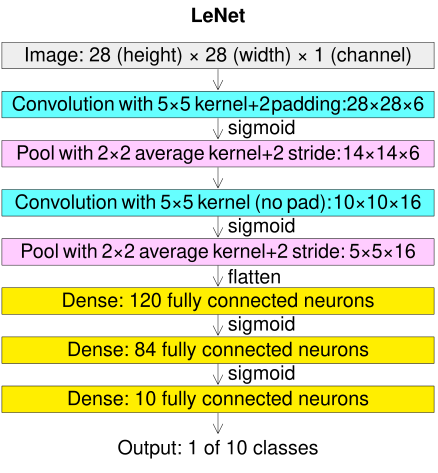

- reduce the image size increase the channels. 

**Flatten**
- torch.reshape: https://docs.pytorch.org/docs/stable/generated/torch.reshape.html 
- Flatten Layer: https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html 

**Softmax**
- Torch Softmax: https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html 

**Linear**
- Linear layer: https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html 

**AvgPooling 2D**
- https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html 

### Define the model

In [ ]:
# Instantiate the model
model = LeNet()

# Summarize the model
summary(model)

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

In [ ]:
# Summarize the model
summary(model)

In [ ]:
# CHeck on the image shape
# images.shape

In [ ]:
# Check on the model shape: ([batch_size, channels])
# model(images).shape

In [ ]:
# Check that the sum of theprobability of each labels is 1.
# model(images).sum(axis = 1)

## Train the model

# LeNet - Modified

Sustitute the reshape layer in the model definition with a globalAveragePooling (AdaptativeAvgPool2d with output_size of 1) layer. After this layer a squeeze is needed so the dimensions with a value of 1 are removed. This is a smaller model, with less paramethers so it is bettter for the small dataset we have.

In [ ]:
from le_net_models import LeNetMod

In [ ]:
# Instantiate the model
model = LeNetMod()

In [ ]:
import pytorch_warmup as warmup

# Instantiate the model
model = LeNetMod()

# Summarize the model
summary(model)

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

In [ ]:
# # Tensor Board Logs Class
# writer = SummaryWriter()

# # Define a training step to keep track of the logs for each step.
# training_step = 0

# # Define the training epochs.
# epocs = 2500

# # Define the Optimizer
# optimizer = torch.optim.Adam(
#     model.parameters(), 
#     lr = 0.0001
#     )

# for epoch in range(epocs):
#   epoc_metrics = {
#     'train': {'loss': 0, 'accuracy': 0, 'count': 0},
#     'val': {'loss': 0, 'accuracy': 0, 'count': 0},
#   }

#   print(f"======================= Epoch: {epoch} =======================")

#   for phase in ['val', 'train']:
#     print(f"======================= Phase: {phase} ======================= ")
#     for images, labels in dataloaders[phase]:
#       batch_size = len(labels)
      
#       optimizer.zero_grad() # Reset the gradients to zero before each batch

#       with torch.set_grad_enabled(phase == 'train'):
#         output = model(images.to(device))
#         one_hot_encoding_labels = torch.nn.functional.one_hot(
#           labels, 
#           num_classes = 6
#           )

#         loss = loss_fn(output, one_hot_encoding_labels.float().to(device))
        
#         predicted_labels = torch.argmax(output, dim = 1)
#         correct_preds = labels.to(device) == predicted_labels
#         accuracy = (correct_preds).sum()/batch_size
        
#       if phase == 'train':
#         training_step +=1
#         loss.backward()
#         optimizer.step()
      
#         # Add the loss and epoch to the tensorboard
#         writer.add_scalar("Train/Loss", loss, training_step)
#         writer.add_scalar("Train/Accuracy", accuracy, training_step)
        
#       epoc_metrics[phase]['loss'] += loss.item()
#       epoc_metrics[phase]['accuracy'] += accuracy.item()
#       epoc_metrics[phase]['count'] += 1
      
    
#     ep_loss = epoc_metrics[phase]['loss']/epoc_metrics[phase]['count']
#     ep_accuracy = epoc_metrics[phase]['accuracy']/epoc_metrics[phase]['count']
    
#     writer.add_scalar(f"{phase.capitalize()}/EpochLoss", ep_loss, training_step)
#     writer.add_scalar(f"{phase.capitalize()}/EpochAccuracy", ep_accuracy, training_step)
    
#     print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

#     metrics[phase]['loss'].append(ep_loss)
#     metrics[phase]['accuracy'].append(ep_accuracy)
    
# writer.flush()  # Tensorboard: Add all the pending events

# LeNet - Modified + Batch normalization of 1 conv

In [ ]:
from le_net_models import LeNetModNorm

In [ ]:
# Instantiate the model
model = LeNetModNorm()

In [ ]:
import pytorch_warmup as warmup

# Instantiate the model
model = LeNetModNorm()

# Summarize the model
summary(model)

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

In [ ]:
# for epoch in range(epocs):
#   epoc_metrics = {
#     'train': {'loss': 0, 'accuracy': 0, 'count': 0},
#     'val': {'loss': 0, 'accuracy': 0, 'count': 0},
#   }

#   print(f"======================= Epoch: {epoch} =======================")

#   for phase in ['val', 'train']:
#     print(f"======================= Phase: {phase} ======================= ")
#     for images, labels in dataloaders[phase]:
#       batch_size = len(labels)
      
#       optimizer.zero_grad() # Reset the gradients to zero before each batch

#       with torch.set_grad_enabled(phase == 'train'):
#         output = model(images.to(device))
#         one_hot_encoding_labels = torch.nn.functional.one_hot(
#           labels, 
#           num_classes = 6
#           )

#         loss = loss_fn(output, one_hot_encoding_labels.float().to(device))
        
#         predicted_labels = torch.argmax(output, dim = 1)
#         correct_preds = labels.to(device) == predicted_labels
#         accuracy = (correct_preds).sum()/batch_size
        
#       if phase == 'train':
#         model.train()
#         training_step +=1
#         loss.backward()
#         optimizer.step()
      
#         # Add the loss and epoch to the tensorboard
#         writer.add_scalar("Train/Loss", loss, training_step)
#         writer.add_scalar("Train/Accuracy", accuracy, training_step)
#       else:
#         model.eval()
#       epoc_metrics[phase]['loss'] += loss.item()
#       epoc_metrics[phase]['accuracy'] += accuracy.item()
#       epoc_metrics[phase]['count'] += 1
      
#     -
#     ep_loss = epoc_metrics[phase]['loss']/epoc_metrics[phase]['count']
#     ep_accuracy = epoc_metrics[phase]['accuracy']/epoc_metrics[phase]['count']
    
#     writer.add_scalar(f"{phase.capitalize()}/EpochLoss", ep_loss, training_step)
#     writer.add_scalar(f"{phase.capitalize()}/EpochAccuracy", ep_accuracy, training_step)
    
#     print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

#     metrics[phase]['loss'].append(ep_loss)
#     metrics[phase]['accuracy'].append(ep_accuracy)
    
# writer.flush()  # Tensorboard: Add all the pending events

---

# LeNet - Modified + Batch normalization of all conv

In [ ]:
from le_net_models import LeNetModNorm2

In [ ]:
import pytorch_warmup as warmup

# Instantiate the model
model = LeNetModNorm2()

# Summarize the model
summary(model)

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

In [ ]:
# for epoch in range(epocs):
#   epoc_metrics = {
#     'train': {'loss': 0, 'accuracy': 0, 'count': 0},
#     'val': {'loss': 0, 'accuracy': 0, 'count': 0},
#   }

#   print(f"======================= Epoch: {epoch} =======================")

#   for phase in ['val', 'train']:
#     print(f"======================= Phase: {phase} ======================= ")
#     for images, labels in dataloaders[phase]:
#       batch_size = len(labels)
      
#       optimizer.zero_grad() # Reset the gradients to zero before each batch

#       with torch.set_grad_enabled(phase == 'train'):
#         output = model(images.to(device))
#         one_hot_encoding_labels = torch.nn.functional.one_hot(
#           labels, 
#           num_classes = 6
#           )

#         loss = loss_fn(output, one_hot_encoding_labels.float().to(device))
        
#         predicted_labels = torch.argmax(output, dim = 1)
#         correct_preds = labels.to(device) == predicted_labels
#         accuracy = (correct_preds).sum()/batch_size
        
#       if phase == 'train':
#         model.train()
#         training_step +=1
#         loss.backward()
#         optimizer.step()
      
#         # Add the loss and epoch to the tensorboard
#         writer.add_scalar("Train/Loss", loss, training_step)
#         writer.add_scalar("Train/Accuracy", accuracy, training_step)
#       else:
#         model.eval()
#       epoc_metrics[phase]['loss'] += loss.item()
#       epoc_metrics[phase]['accuracy'] += accuracy.item()
#       epoc_metrics[phase]['count'] += 1
      
#     ep_loss = epoc_metrics[phase]['loss']/epoc_metrics[phase]['count']
#     ep_accuracy = epoc_metrics[phase]['accuracy']/epoc_metrics[phase]['count']
    
#     writer.add_scalar(f"{phase.capitalize()}/EpochLoss", ep_loss, training_step)
#     writer.add_scalar(f"{phase.capitalize()}/EpochAccuracy", ep_accuracy, training_step)
    
#     print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

#     metrics[phase]['loss'].append(ep_loss)
#     metrics[phase]['accuracy'].append(ep_accuracy)
    
# writer.flush()  # Tensorboard: Add all the pending events

---

# Alex-Net

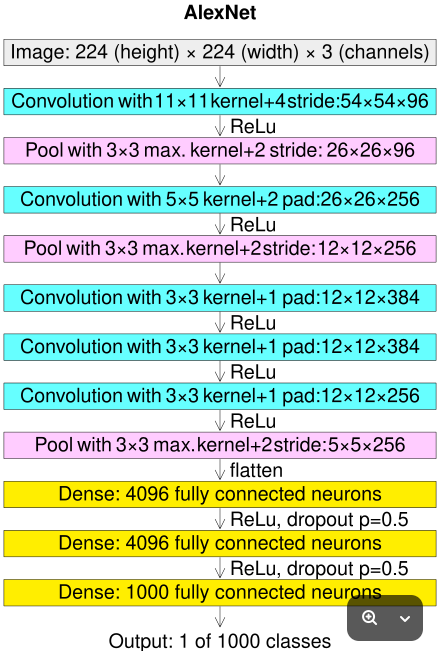

## Define the model

In [ ]:
from alex_net_model import AlexNet

In [ ]:
import pytorch_warmup as warmup

# Instantiate the model
model = AlexNet()

# Summarize the model
summary(model)

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

In [ ]:
# for epoch in range(epocs):
#   epoc_metrics = {
#     'train': {'loss': 0, 'accuracy': 0, 'count': 0},
#     'val': {'loss': 0, 'accuracy': 0, 'count': 0},
#   }

#   print(f"======================= Epoch: {epoch} =======================")

#   for phase in ['val', 'train']:
#     print(f"======================= Phase: {phase} ======================= ")
#     for images, labels in dataloaders[phase]:
#       batch_size = len(labels)
      
#       optimizer.zero_grad() # Reset the gradients to zero before each batch

#       with torch.set_grad_enabled(phase == 'train'):
#         output = model(images.to(device))
#         one_hot_encoding_labels = torch.nn.functional.one_hot(
#           labels, 
#           num_classes = 6
#           )

#         loss = loss_fn(output, one_hot_encoding_labels.float().to(device))
        
#         predicted_labels = torch.argmax(output, dim = 1)
#         correct_preds = labels.to(device) == predicted_labels
#         accuracy = (correct_preds).sum()/batch_size
        
#       if phase == 'train':
#         model.train()
#         training_step +=1
#         loss.backward()
#         optimizer.step()
      
#         # Add the loss and epoch to the tensorboard
#         writer.add_scalar("Train/Loss", loss, training_step)
#         writer.add_scalar("Train/Accuracy", accuracy, training_step)
#       else:
#         model.eval()
#       epoc_metrics[phase]['loss'] += loss.item()
#       epoc_metrics[phase]['accuracy'] += accuracy.item()
#       epoc_metrics[phase]['count'] += 1
      
#     ep_loss = epoc_metrics[phase]['loss']/epoc_metrics[phase]['count']
#     ep_accuracy = epoc_metrics[phase]['accuracy']/epoc_metrics[phase]['count']
    
#     writer.add_scalar(f"{phase.capitalize()}/EpochLoss", ep_loss, training_step)
#     writer.add_scalar(f"{phase.capitalize()}/EpochAccuracy", ep_accuracy, training_step)
    
#     print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

#     metrics[phase]['loss'].append(ep_loss)
#     metrics[phase]['accuracy'].append(ep_accuracy)
    
# writer.flush()  # Tensorboard: Add all the pending events

**Learnings**: When the Training Loss goes up and accuracy goes down means that the model is not learning probably because of a high learning rate.    

Using the library `pytorch_warmup` to  link: https://github.com/Tony-Y/pytorch_warmup 

# Trainer defined in a function

In [ ]:
import pytorch_warmup as warmup

# Instantiate the model
model = AlexNet()

# Summarize the model
summary(model)

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

---

# InceptioNet / GoogleNet

In [ ]:
from models.inceptionet_new import GoogLeNet
import pytorch_warmup as warmup
from trainer import train

# Instantiate the model
model = GoogLeNet()

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

---

# ResNet

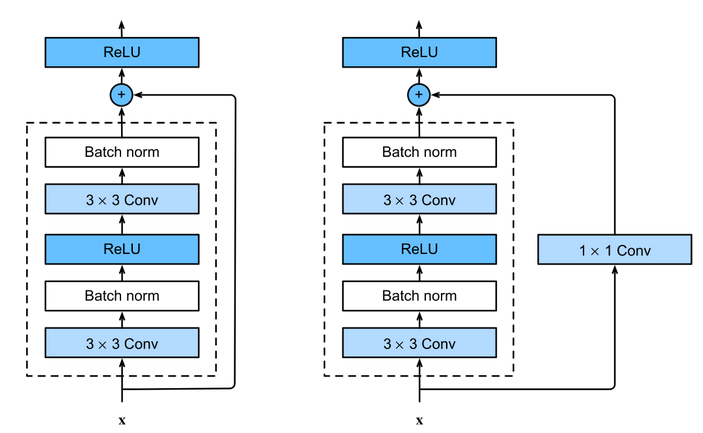

In [ ]:
class ResNetBlock(torch.nn.Module):
  def __init__(self, in_channels = 64, out_channels = 256,  kernel_size = 3, stride = 2):
    super(ResNetBlock, self).__init__()
    self.conv_1 = torch.nn.Conv2d(in_channels = in_channels, out_channels = in_channels, kernel_size=kernel_size, stride = stride, padding = (kernel_size - 1)//2) # stride = 1 => Shape (b, 64, w, h) | # stride = 2 => Shape (b, 64, w/2, h/2)
    self.conv_2 = torch.nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size=kernel_size, stride = 1, padding = "same")     # stride = 2 => (b, 256, w/2, h/2) | stride = 1 =>    (b, 256, w/2, h/2)
    self.activation = torch.nn.ReLU()
    self.batch_norm_1 = torch.nn.BatchNorm2d(in_channels)
    self.batch_norm_2 = torch.nn.BatchNorm2d(in_channels)
    self.residual_conv = None
    if in_channels != out_channels or stride > 1:
      self.residual_conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = 1, stride = stride) # Shape: b, 256, w/2, h/2
    
  def forward(self, x):
    h = self.batch_norm_1(x) # Shape: (batch_size, channels, 30, 30)
    h = self.conv_1(h) # Shape: (batch_size, channels, 15, 15)
    h = self.activation(h)

    h = self.batch_norm_2(h) # Shape: (batch_size, channels, 15, 15)
    h = self.conv_2(h) # Shape: (batch_size, channels, 15, 15)
    h = self.activation(h)
    if self.residual_conv is not None:
      x = self.residual_conv(x)
    return x + h


In [ ]:
class ResNet(torch.nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.conv_1 = torch.nn.Conv2d(in_channels = 3 , out_channels = 64, kernel_size = 7, stride = 2)
    self.max_pool = torch.nn.MaxPool2d(kernel_size = 3, stride = 2)
    self.adaptive_avg_pool = torch.nn.AdaptiveAvgPool2d(output_size = 1)
    self.block_1 = ResNetBlock(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 2)
    self.block_2 = ResNetBlock(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 2)
    self.block_3 = ResNetBlock(in_channels = 128, out_channels =256, kernel_size = 3, stride = 2)
    self.fully_connected = torch.nn.Linear(in_features = 256, out_features = 6)
    self.softmax = torch.nn.Softmax()
    self.activation = torch.nn.ReLU()

  def forward(self, x):
    # Input size: (batch_size, 3, 128, 128)
    x = self.conv_1(x) # Shape: (batch_size, 64, 61, 61)
    x = self.activation(x)
    x = self.max_pool(x) # Shape: (batch_size, 64, 30, 30)

    x = self.block_1(x) # Shape: (batch_size, 64, 15, 15)
    x = self.block_2(x) # Shape: (batch_size, 128, 8, 8)
    x = self.block_3(x) # Shape: (batch_size, 64, 4, 4)

    x = self.adaptive_avg_pool(x) # Shape: (batch_size, 256, 1, 1)
    x = torch.squeeze(x)  #Shape: (batch_size, 256)
    x = self.fully_connected(x) # Shape: (batch_size, 84)
    x = self.softmax(x)
    return x

In [ ]:
import pytorch_warmup as warmup
from trainer import train

# Instantiate the model
model = ResNet()

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

# DenseNet

In [ ]:
from models.densenet import DenseNet
import pytorch_warmup as warmup
from trainer import train

# Instantiate the model
model = DenseNet()

In [ ]:
from torchinfo import summary
summary(model)

In [ ]:
from models.densenet import DenseNet
import pytorch_warmup as warmup
from trainer import train

# Instantiate the model
model = DenseNet()

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

# VIT

In [ ]:
from models.vit import Vit
import pytorch_warmup as warmup
from trainer import train

# Instantiate the model
model = Vit()

In [ ]:
type(model)

In [ ]:
from torchinfo import summary
summary(model)

In [ ]:
import pytorch_warmup as warmup
from trainer import train

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

# VIT + poss emb

In [ ]:
from models.vit import Vit
import pytorch_warmup as warmup
from trainer import train

# Instantiate the model
model = Vit()

In [ ]:
# params = [item for item in model.parameters()]
# params

In [ ]:
# params_2 = [item for item in model.named_parameters()]
# params_2[1]

In [ ]:
# list(model.named_parameters())[0]

In [ ]:
from torchinfo import summary
summary(model)

In [ ]:
import pytorch_warmup as warmup
from trainer import train

# Define the training epochs.
epochs = 2500

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

# Define the warmup scheduler
warmup_scheduler = warmup.LinearWarmup(optimizer, 2000)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss.
# loss_fn = torch.nn.CrossEntropyLoss() 

# Tensor Board Logs Class
writer = SummaryWriter()

train(epochs = epochs, dataloaders = dataloaders, optimizer=optimizer, device=device, model = model, writer = writer, warmup_scheduler = warmup_scheduler)

In [ ]:
# %debug

# Extra notes

Run tensorboard: `tensorboard --logdir=runs`

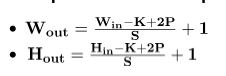

PlantVillage Dataset: 
- Link: https://www.kaggle.com/datasets/emmarex/plantdisease/data 
- Dataset of diseased plant leaf images and corresponding labels
- Notebook interesante: https://www.kaggle.com/code/shawon10/plant-disease-classification-using-densenet121
- Interesting app: https://github.com/shawon100/Plant-Disease-Diagnosis-Flask?tab=readme-ov-file 